In [1]:
# Cell 1: Install Required Libraries
# ----------------------------------------------------------------------------
!pip install -q transformers datasets torch accelerate scikit-learn evaluate
!pip install accelerate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [2]:
# Cell 1.5: Clean reinstall of Hugging Face Libraries
# Ensuring accelerate>=0.26.0 and peft are installed along with transformers.
# Includes runtime restart to ensure changes take effect.
!pip install --no-cache-dir --upgrade  transformers==4.57.1 accelerate peft

In [3]:
# Cell 1.6: Verify correct version and constructor
import transformers, inspect
from transformers import TrainingArguments

print("Transformers version:", transformers.__version__)
print("TrainingArguments source:", TrainingArguments.__module__)
print("\nConstructor signature:")
print(inspect.signature(TrainingArguments.__init__))


Transformers version: 4.57.1
TrainingArguments source: transformers.training_args

Constructor signature:
(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr

In [4]:
# Cell 2: Import All Required Libraries
import os
import torch
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [5]:
# Cell 3: Check GPU Availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available. Training will be slower on CPU.")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.83 GB
CUDA Version: 12.6


In [15]:
# Cell 4: Load Datasets from Current Folder
import glob

# List all CSV files in the provided directory
csv_files = glob.glob('/content/drive/MyDrive/Colab/Task_01_Encoder/emotion_dataset/*.csv')
print(f"Found CSV files in Task_01_Encoder folder: {csv_files}")

# Load emotion labels mapping (emotion_labels.csv)
# Added error handling for when files are not found
if not csv_files:
    raise FileNotFoundError("No CSV files found in the specified directory. Please check the path.")

labels_file = [f for f in csv_files if 'label' in f.lower()]
if not labels_file:
    raise FileNotFoundError("Emotion labels file ('*label*.csv') not found in the specified directory.")
labels_file = labels_file[0]
emotion_labels_df = pd.read_csv(labels_file)

print(f"\nLoaded emotion labels from: {labels_file}")
print(f"Labels shape: {emotion_labels_df.shape}")
print(f"Labels columns: {emotion_labels_df.columns.tolist()}")
print("\nEmotion Labels Mapping:")
print(emotion_labels_df)

# Load main dataset (emotions-dataset.csv)
dataset_file = [f for f in csv_files if 'dataset' in f.lower()]
if not dataset_file:
    raise FileNotFoundError("Main dataset file ('*dataset*.csv') not found in the specified directory.")
dataset_file = dataset_file[0]
df = pd.read_csv(dataset_file)

print(f"\nLoaded main dataset from: {dataset_file}")
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")

Found CSV files in Task_01_Encoder folder: ['/content/drive/MyDrive/Colab/Task_01_Encoder/emotion_dataset/emotions-dataset.csv', '/content/drive/MyDrive/Colab/Task_01_Encoder/emotion_dataset/emotion_labels.csv']

Loaded emotion labels from: /content/drive/MyDrive/Colab/Task_01_Encoder/emotion_dataset/emotion_labels.csv
Labels shape: (4, 2)
Labels columns: ['label', 'emotion']

Emotion Labels Mapping:
   label  emotion
0      0      Joy
1      1  Sadness
2      2  Neutral
3      3    Anger

Loaded main dataset from: /content/drive/MyDrive/Colab/Task_01_Encoder/emotion_dataset/emotions-dataset.csv
Dataset shape: (22050, 2)
Dataset columns: ['content', 'sentiment']


In [16]:
import os

# List contents of the directory specified in glob.glob
directory_path = '/content/drive/MyDrive/Colab Notebooks/Project_02/Task_01_Encoder/emotion_dataset/'
print(f"Contents of {directory_path}:")
try:
    for item in os.listdir(directory_path):
        print(item)
except FileNotFoundError:
    print(f"Error: Directory not found at {directory_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Contents of /content/drive/MyDrive/Colab Notebooks/Project_02/Task_01_Encoder/emotion_dataset/:
Error: Directory not found at /content/drive/MyDrive/Colab Notebooks/Project_02/Task_01_Encoder/emotion_dataset/


In [17]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [18]:
# Cell 5: Explore the Dataset
print("="*70)
print("DATASET EXPLORATION")
print("="*70)

# Display top  5 rows
print(df.head())

# To check the columns inside the dataset
text_col = df.columns[0]
label_col = df.columns[1]

print(f"\nIdentified columns:")
print(f"  Text column: {text_col}")
print(f"  Label column: {label_col}")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Label distribution
print(f"\nLabel distribution (numeric):")
print(df[label_col].value_counts().sort_index())

print(f"\nLabel distribution (percentages):")
print(df[label_col].value_counts(normalize=True).sort_index() * 100)

# Display sample texts
print("\nSample texts:")
for i in range(min(3, len(df))):
    print(f"\n{i+1}. {df[text_col].iloc[i][:100]}...")
    print(f"   Label: {df[label_col].iloc[i]}")

DATASET EXPLORATION
                                             content  sentiment
0                   not a very good day at the house          1
1  tommcfly i saw you on tues and last niiiighht ...          2
2     i dont even understand the intro to this book           3
3      happy mothers day mommy and grandma haha  ily          0
4  quotoh i got so fucked up last nightquot but u...          3

Identified columns:
  Text column: content
  Label column: sentiment

Missing values:
content      0
sentiment    0
dtype: int64

Label distribution (numeric):
sentiment
0    5827
1    5165
2    5209
3    5849
Name: count, dtype: int64

Label distribution (percentages):
sentiment
0    26.426304
1    23.424036
2    23.623583
3    26.526077
Name: proportion, dtype: float64

Sample texts:

1. not a very good day at the house...
   Label: 1

2. tommcfly i saw you on tues and last niiiighht lt3 so amazzzing didnt even notice you forgetting the ...
   Label: 2

3. i dont even understand the int

In [19]:
# Cell 6: Create label mapping and merge emotion names
print("="*70)
print("CREATING LABEL MAPPING")
print("="*70)

# Create label to emotion name mapping from emotion_labels.csv
# Assuming columns are: column 0 = label_id (0-3), column 1 = emotion_name
label_mapping_df = emotion_labels_df.copy()
label_col_name = label_mapping_df.columns[0]
emotion_col_name = label_mapping_df.columns[1]

# Create dictionaries for mapping
id2label = dict(zip(label_mapping_df[label_col_name], label_mapping_df[emotion_col_name]))
label2id = {v: k for k, v in id2label.items()}

print(f"\nLabel to Emotion Mapping (id2label):")
for label_id, emotion in id2label.items():
    print(f"  {label_id} -> {emotion}")

print(f"\nEmotion to Label Mapping (label2id):")
for emotion, label_id in label2id.items():
    print(f"  {emotion} -> {label_id}")

# Rename columns for consistency
df = df.rename(columns={text_col: 'text', label_col: 'label'})

# Map numeric labels to emotion names
df['emotion'] = df['label'].map(id2label)

# Verify mapping
print(f"\nDataset after adding emotion names:")
print(df[['text', 'label', 'emotion']].head(10))

# Get list of emotion labels for later use
emotion_labels = sorted(df['emotion'].unique().tolist())
print(f"\nEmotion classes: {emotion_labels}")


CREATING LABEL MAPPING

Label to Emotion Mapping (id2label):
  0 -> Joy
  1 -> Sadness
  2 -> Neutral
  3 -> Anger

Emotion to Label Mapping (label2id):
  Joy -> 0
  Sadness -> 1
  Neutral -> 2
  Anger -> 3

Dataset after adding emotion names:
                                                text  label  emotion
0                   not a very good day at the house      1  Sadness
1  tommcfly i saw you on tues and last niiiighht ...      2  Neutral
2     i dont even understand the intro to this book       3    Anger
3      happy mothers day mommy and grandma haha  ily      0      Joy
4  quotoh i got so fucked up last nightquot but u...      3    Anger
5  this tea fucking sucks where the fuck is my co...      3    Anger
6            nerdindian take that back i am insulted      3    Anger
7  and even though they got good reviews and are ...      3    Anger
8  saw the blink show from the tmobile party im s...      0      Joy
9  moveout should be fun thank you vt students fo...      2  Neutr

In [20]:
# Cell 6.5: Enhanced Data Preprocessing and Cleaning
print("ENHANCED DATA PREPROCESSING")
import re
import string

def clean_text(text):
    """
    Comprehensive text cleaning function
    - Handles URLs, mentions, special characters
    - Normalizes text for better BERT performance
    - Preserves emotional content
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)

    # Remove user mentions and hashtags
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Handle common contractions for emotional expressions
    contractions = {
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }

    for cont, expanded in contractions.items():
        text = text.replace(cont, expanded)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    return text.strip()

# Remove any rows with missing values
original_size = len(df)
df = df.dropna(subset=['text', 'label', 'emotion'])
print(f"Removed {original_size - len(df)} rows with missing values")

# Remove duplicate texts
df = df.drop_duplicates(subset=['text'])
print(f"Dataset size after removing duplicates: {len(df)}")

# Apply text cleaning
print("Applying text cleaning...")
df['cleaned_text'] = df['text'].apply(clean_text)

# Remove empty texts after cleaning
df = df[df['cleaned_text'].str.strip() != '']
print(f"Dataset size after cleaning: {len(df)}")

# Verify all labels are valid
invalid_labels = df[~df['label'].isin(id2label.keys())]
if len(invalid_labels) > 0:
    print(f"\nWarning: Found {len(invalid_labels)} rows with invalid labels. Removing them.")
    df = df[df['label'].isin(id2label.keys())]

print(f"\nFinal dataset shape: {df.shape}")
print(f"Number of classes: {len(emotion_labels)}")

# Display final statistics
print(f"\nFinal emotion distribution:")
emotion_dist = df['emotion'].value_counts().sort_index()
print(emotion_dist)

# Check for class imbalance
print(f"\nClass balance analysis:")
total_samples = len(df)
for emotion, count in emotion_dist.items():
    percentage = (count / total_samples) * 100
    print(f"  {emotion}: {count} samples ({percentage:.1f}%)")

# Sample from each emotion with cleaned text
print("\nSample cleaned texts from each emotion:")
for emotion in emotion_labels:
    if emotion in df['emotion'].values:
        original_text = df[df['emotion'] == emotion]['text'].iloc[0]
        cleaned_text = df[df['emotion'] == emotion]['cleaned_text'].iloc[0]
        label = df[df['emotion'] == emotion]['label'].iloc[0]
        print(f"\n{emotion.upper()} (Label: {label}):")
        print(f"  Original: {original_text[:80]}...")
        print(f"  Cleaned:  {cleaned_text[:80]}...")

# Update text column to use cleaned text
df['text'] = df['cleaned_text']
df = df.drop('cleaned_text', axis=1)

ENHANCED DATA PREPROCESSING
Removed 0 rows with missing values
Dataset size after removing duplicates: 21923
Applying text cleaning...
Dataset size after cleaning: 21922

Final dataset shape: (21922, 4)
Number of classes: 4

Final emotion distribution:
emotion
Anger      5816
Joy        5793
Neutral    5168
Sadness    5145
Name: count, dtype: int64

Class balance analysis:
  Anger: 5816 samples (26.5%)
  Joy: 5793 samples (26.4%)
  Neutral: 5168 samples (23.6%)
  Sadness: 5145 samples (23.5%)

Sample cleaned texts from each emotion:

ANGER (Label: 3):
  Original: i dont even understand the intro to this book ...
  Cleaned:  i dont even understand the intro to this book...

JOY (Label: 0):
  Original: happy mothers day mommy and grandma haha  ily...
  Cleaned:  happy mothers day mommy and grandma haha ily...

NEUTRAL (Label: 2):
  Original: tommcfly i saw you on tues and last niiiighht lt3 so amazzzing didnt even notice...
  Cleaned:  tommcfly i saw you on tues and last niiiighht lt so 

In [21]:
# Cell 7: Train-Validation-Test Split (Stratified)
print("DATASET SPLITTING")

# Split: 80% train, 10% validation, 10% test
# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Second split: split temp into 50-50 for validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Verify stratification worked
print(f"\n{'='*70}")
print("Verifying stratification:")
print(f"\nTrain distribution:")
print(train_df['emotion'].value_counts().sort_index())
print(f"\nValidation distribution:")
print(val_df['emotion'].value_counts().sort_index())
print(f"\nTest distribution:")
print(test_df['emotion'].value_counts().sort_index())

DATASET SPLITTING
Train set size: 17537
Validation set size: 2192
Test set size: 2193

Verifying stratification:

Train distribution:
emotion
Anger      4653
Joy        4634
Neutral    4134
Sadness    4116
Name: count, dtype: int64

Validation distribution:
emotion
Anger      581
Joy        579
Neutral    517
Sadness    515
Name: count, dtype: int64

Test distribution:
emotion
Anger      582
Joy        580
Neutral    517
Sadness    514
Name: count, dtype: int64


In [22]:
# Cell 8: Convert to Hugging Face Dataset Format
# Create HuggingFace datasets in dictionary form key value pairs
train_dataset = Dataset.from_pandas(
    train_df[['text', 'label']].reset_index(drop=True)
)
val_dataset = Dataset.from_pandas(
    val_df[['text', 'label']].reset_index(drop=True)
)
test_dataset = Dataset.from_pandas(
    test_df[['text', 'label']].reset_index(drop=True)
)

# Combine into DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("Dataset converted to HuggingFace format:")
print(dataset_dict)


Dataset converted to HuggingFace format:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 17537
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2192
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2193
    })
})


In [23]:
# Cell 9: Load BERT Tokenizer
print("LOADING BERT TOKENIZER")
# Load pre-trained BERT tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

print(f"Tokenizer: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Max length: {tokenizer.model_max_length}")

# Test tokenization with a sample
sample_text = df['text'].iloc[0]
print(f"\nExample tokenization:")
print(f"Input text: {sample_text[:100]}...")
encoded = tokenizer(sample_text, truncation=True, padding='max_length', max_length=128)
print(f"Input IDs length: {len(encoded['input_ids'])}")
print(f"First 20 tokens: {encoded['input_ids'][:20]}")

LOADING BERT TOKENIZER


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer: bert-base-uncased
Vocabulary size: 30522
Max length: 512

Example tokenization:
Input text: not a very good day at the house...
Input IDs length: 128
First 20 tokens: [101, 2025, 1037, 2200, 2204, 2154, 2012, 1996, 2160, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
# Cell 10: Enhanced Tokenization with Dynamic Padding
print("ENHANCED TOKENIZATION WITH DYNAMIC PADDING")
# Analyze text length for optimal max_length
text_lengths = df['text'].str.split().str.len()
print(f"Text length statistics:")
print(f"  Mean: {text_lengths.mean():.1f}")
print(f"  Std: {text_lengths.std():.1f}")
print(f"  Min: {text_lengths.min()}")
print(f"  Max: {text_lengths.max()}")
print(f"  95th percentile: {text_lengths.quantile(0.95):.1f}")
# Choose max_length based on data analysis
optimal_max_length = min(256, int(text_lengths.quantile(0.95)) + 10)
print(f"\nSelected max_length: {optimal_max_length}")

def enhanced_tokenize_function(examples):
    """
    Enhanced tokenization with dynamic padding and attention masks
    - Uses optimal max_length based on data analysis
    - Returns attention masks for better BERT performance
    - More efficient memory usage
    """
    try:
        tokenized = tokenizer(
            examples['text'],
            truncation=True,
            padding=False,  # We'll handle padding dynamically in data collator
            max_length=optimal_max_length,
            return_attention_mask=True,
            return_token_type_ids=False,  # Not needed for single sentences
            add_special_tokens=True
        )
        return tokenized
    except Exception as e:
        print(f"Tokenization error: {e}")
        # Return empty tokens for error cases
        return {'input_ids': [], 'attention_mask': []}

# Apply enhanced tokenization to all splits
print("Tokenizing training set...")
tokenized_train = dataset_dict['train'].map(
    enhanced_tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing train",
    batch_size=1000  # Process in larger batches for efficiency
)

print("Tokenizing validation set...")
tokenized_val = dataset_dict['validation'].map(
    enhanced_tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing validation",
    batch_size=1000
)
print("Tokenizing test set...")
tokenized_test = dataset_dict['test'].map(
    enhanced_tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing test",
    batch_size=1000
)
# Verify tokenization
print("\nTokenization verification:")
sample_idx = 0
print(f"Sample input IDs length: {len(tokenized_train[sample_idx]['input_ids'])}")
print(f"Sample attention mask length: {len(tokenized_train[sample_idx]['attention_mask'])}")
print(f"Sample input IDs (first 10): {tokenized_train[sample_idx]['input_ids'][:10]}")
# Create final tokenized dataset
tokenized_datasets = DatasetDict({
    'train': tokenized_train,
    'validation': tokenized_val,
    'test': tokenized_test
})
print("\nEnhanced tokenization complete!")
print(f"Training samples: {len(tokenized_datasets['train'])}")
print(f"Validation samples: {len(tokenized_datasets['validation'])}")
print(f"Test samples: {len(tokenized_datasets['test'])}")

ENHANCED TOKENIZATION WITH DYNAMIC PADDING
Text length statistics:
  Mean: 12.5
  Std: 6.8
  Min: 1
  Max: 32
  95th percentile: 25.0

Selected max_length: 35
Tokenizing training set...


Tokenizing train:   0%|          | 0/17537 [00:00<?, ? examples/s]

Tokenizing validation set...


Tokenizing validation:   0%|          | 0/2192 [00:00<?, ? examples/s]

Tokenizing test set...


Tokenizing test:   0%|          | 0/2193 [00:00<?, ? examples/s]


Tokenization verification:
Sample input IDs length: 7
Sample attention mask length: 7
Sample input IDs (first 10): [101, 7592, 2045, 4402, 4402, 4402, 102]

Enhanced tokenization complete!
Training samples: 17537
Validation samples: 2192
Test samples: 2193


In [25]:
# Cell 11: Load Pre-trained BERT Model for Sequence Classification
print("LOADING BERT MODEL")
num_labels = len(label2id)
# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
# Move model to GPU if available
model = model.to(device)
print(f"Model: {model_name}")
print(f"Number of labels: {num_labels}")
print(f"Total parameters: {model.num_parameters():,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Model device: {next(model.parameters()).device}")

LOADING BERT MODEL


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: bert-base-uncased
Number of labels: 4
Total parameters: 109,485,316
Trainable parameters: 109,485,316
Model device: cuda:0


In [26]:
# Cell 12:  Evaluation Metrics Function
from sklearn.metrics import precision_score, recall_score, classification_report
import json

def compute_metrics(eval_pred):
    """
    Enhanced evaluation metrics with comprehensive analysis
    - Includes precision, recall for each class
    - Handles edge cases and invalid predictions
    - Returns detailed per-class metrics
    """
    try:
        predictions, labels = eval_pred

        # Handle logits from transformer models
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        else:
            # For binary classification or already processed predictions
            predictions = predictions.flatten()

        # Ensure labels are integers
        labels = labels.astype(int)
        predictions = predictions.astype(int)

        # Calculate basic metrics
        accuracy = accuracy_score(labels, predictions)
        f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
        f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
        precision_macro = precision_score(labels, predictions, average='macro', zero_division=0)
        recall_macro = recall_score(labels, predictions, average='macro', zero_division=0)

        # Calculate per-class metrics
        precision_per_class = precision_score(labels, predictions, average=None, zero_division=0)
        recall_per_class = recall_score(labels, predictions, average=None, zero_division=0)
        f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)

        # Create per-class metrics dictionary
        per_class_metrics = {}
        for i, emotion in enumerate(emotion_labels):
            per_class_metrics[f'precision_{emotion}'] = float(precision_per_class[i])
            per_class_metrics[f'recall_{emotion}'] = float(recall_per_class[i])
            per_class_metrics[f'f1_{emotion}'] = float(f1_per_class[i])

        # Compile all metrics
        metrics = {
            'accuracy': float(accuracy),
            'f1_macro': float(f1_macro),
            'f1_weighted': float(f1_weighted),
            'precision_macro': float(precision_macro),
            'recall_macro': float(recall_macro),
            **per_class_metrics
        }

        return metrics

    except Exception as e:
        print(f"Error in compute_metrics: {e}")
        # Return basic metrics in case of error
        return {
            'accuracy': 0.0,
            'f1_macro': 0.0,
            'f1_weighted': 0.0,
            'precision_macro': 0.0,
            'recall_macro': 0.0
        }

print("Enhanced evaluation metrics function defined:")
print("  - Accuracy")
print("  - F1-Score (Macro & Weighted)")
print("  - Precision (Macro & Per-class)")
print("  - Recall (Macro & Per-class)")
print("  - Per-class metrics for all emotions")

# Test the metrics function
print("\nTesting metrics function with sample data...")
sample_predictions = np.random.randint(0, num_labels, (100, num_labels))
sample_labels = np.random.randint(0, num_labels, 100)
sample_metrics = compute_metrics((sample_predictions, sample_labels))
print("Sample metrics test successful!")

Enhanced evaluation metrics function defined:
  - Accuracy
  - F1-Score (Macro & Weighted)
  - Precision (Macro & Per-class)
  - Recall (Macro & Per-class)
  - Per-class metrics for all emotions

Testing metrics function with sample data...
Sample metrics test successful!


In [27]:
# Cell 13: Enhanced Training Configuration with Error Handling
print("ENHANCED TRAINING CONFIGURATION")
training_args = TrainingArguments(
    output_dir='./results',
    overwrite_output_dir=True,

    # Training parameters
    num_train_epochs=4,  # Increased for better convergence
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=500,
    warmup_ratio=0.1,

    # Evaluation and saving
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_macro',
    greater_is_better=True,
    save_total_limit=2,

    # Logging
    logging_dir='./logs',
    logging_steps=50,
    logging_strategy='steps',

    # Optimization
    fp16=torch.cuda.is_available(),
    dataloader_pin_memory=False,  # Reduce memory usage
    gradient_accumulation_steps=1,

    # Reproducibility
    seed=42,
    data_seed=42,

    # Safety and error handling
    max_grad_norm=1.0,  # Gradient clipping
    remove_unused_columns=True,
    report_to='none',
    disable_tqdm=False,
    # Early stopping (via callback)
    # load_best_model_at_end=True, # Removed duplicate

)
print("Enhanced Training Arguments:")
print(f"  Learning Rate: {training_args.learning_rate}")
print(f"  Batch Sizes: Train={training_args.per_device_train_batch_size}, Eval={training_args.per_device_eval_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Warmup Steps: {training_args.warmup_steps}")
print(f"  Weight Decay: {training_args.weight_decay}")
print(f"  FP16 Enabled: {training_args.fp16}")
print(f"  Max Grad Norm: {training_args.max_grad_norm}")
print(f"  Device: {device}")

# Add error handling wrapper for training
def safe_train_model(trainer):
    """
    Enhanced training with error handling and recovery
    """
    try:
        print("Starting training with enhanced configuration...")
        train_result = trainer.train()

        print("\nTraining completed successfully!")
        return train_result

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print("GPU out of memory error detected!")
            print("Attempting recovery with reduced batch size...")

            # Reduce batch size and retry
            training_args.per_device_train_batch_size = 8
            training_args.per_device_eval_batch_size = 16
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_datasets['train'],
                eval_dataset=tokenized_datasets['validation'],
                tokenizer=tokenizer,
                data_collator=data_collator,
                compute_metrics=compute_metrics
            )

            return trainer.train()
        else:
            raise e
    except Exception as e:
        print(f"Training failed with error: {e}")
        raise e

print("\nEnhanced training configuration ready with error handling!")

ENHANCED TRAINING CONFIGURATION
Enhanced Training Arguments:
  Learning Rate: 2e-05
  Batch Sizes: Train=16, Eval=32
  Epochs: 4
  Warmup Steps: 500
  Weight Decay: 0.01
  FP16 Enabled: True
  Max Grad Norm: 1.0
  Device: cuda

Enhanced training configuration ready with error handling!


In [28]:
# Cell 14: Initialize Data Collator and Trainer
# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
print("Trainer initialized successfully!")
print(f"Training samples: {len(tokenized_datasets['train'])}")
print(f"Validation samples: {len(tokenized_datasets['validation'])}")
print(f"Steps per epoch: {len(tokenized_datasets['train']) // training_args.per_device_train_batch_size}")


Trainer initialized successfully!
Training samples: 17537
Validation samples: 2192
Steps per epoch: 1096


In [29]:
# Cell 15: Enhanced Training with Error Handling and Progress Tracking
print("ENHANCED TRAINING WITH ERROR HANDLING")
print(f"Training on {device}")
print()

# Import additional progress tracking
from datetime import datetime
import time

# Start timer
start_time = time.time()
training_start = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Training started at: {training_start}")

try:
    # Start enhanced training
    train_result = safe_train_model(trainer)

    # Calculate training time
    end_time = time.time()
    training_duration = end_time - start_time

    print("\n" + "="*70)
    print("Training Complete Successfully!")
    print("="*70)
    print(f"Final Training Loss: {train_result.training_loss:.4f}")
    print(f"Training Duration: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes)")
    print(f"Training Samples/Second: {train_result.metrics['train_samples_per_second']:.2f}")
    print(f"Training Steps/Second: {train_result.metrics['train_steps_per_second']:.2f}")

    # Save training completion timestamp
    training_metrics = {
        'start_time': training_start,
        'end_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'duration_seconds': training_duration,
        'final_loss': float(train_result.training_loss),
        'samples_per_second': float(train_result.metrics['train_samples_per_second']),
        'steps_per_second': float(train_result.metrics['train_steps_per_second'])
    }

    with open('training_metrics.json', 'w') as f:
        json.dump(training_metrics, f, indent=2)

except Exception as e:
    print(f"\n Training Failed: {e}")
    print("Please check the error message above and adjust parameters accordingly.")
    # Save error information for debugging
    error_info = {
        'error_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'error_type': type(e).__name__,
        'error_message': str(e),
        'device': str(device),
        'batch_size': training_args.per_device_train_batch_size
    }
    with open('training_error.json', 'w') as f:
        json.dump(error_info, f, indent=2)
    raise e

ENHANCED TRAINING WITH ERROR HANDLING
Training on cuda

Training started at: 2025-10-28 06:51:20
Starting training with enhanced configuration...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro,Precision Anger,Recall Anger,F1 Anger,Precision Joy,Recall Joy,F1 Joy,Precision Neutral,Recall Neutral,F1 Neutral,Precision Sadness,Recall Sadness,F1 Sadness
1,0.883000,0.869394,0.640511,0.643818,0.644580,0.661176,0.643156,0.546410,0.538860,0.542609,0.541958,0.601942,0.570377,0.629687,0.779497,0.696629,0.926650,0.652324,0.765657
2,0.766800,0.867536,0.654197,0.658483,0.659686,0.668950,0.653359,0.526003,0.611399,0.565495,0.573801,0.603883,0.588458,0.708502,0.676983,0.692384,0.867495,0.721170,0.787594
3,0.531700,1.013032,0.642792,0.643216,0.643640,0.645818,0.644395,0.552182,0.502591,0.526221,0.553082,0.627184,0.587807,0.660177,0.721470,0.689464,0.817829,0.726334,0.769371
4,0.363600,1.111958,0.645073,0.645898,0.647182,0.648390,0.644156,0.539604,0.564767,0.551899,0.562264,0.578641,0.570335,0.682785,0.682785,0.682785,0.808905,0.750430,0.778571



Training completed successfully!

Training Complete Successfully!
Final Training Loss: 0.6655
Training Duration: 377.08 seconds (6.28 minutes)
Training Samples/Second: 186.24
Training Steps/Second: 11.65


In [30]:
# Cell 16: Evaluate on Validation Set
print("EVALUATING ON VALIDATION SET")
val_results = trainer.evaluate()
print("\n Validation Results:")
for key, value in val_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

EVALUATING ON VALIDATION SET



 Validation Results:
  eval_loss: 0.8675
  eval_accuracy: 0.6542
  eval_f1_macro: 0.6585
  eval_f1_weighted: 0.6597
  eval_precision_macro: 0.6690
  eval_recall_macro: 0.6534
  eval_precision_Anger: 0.5260
  eval_recall_Anger: 0.6114
  eval_f1_Anger: 0.5655
  eval_precision_Joy: 0.5738
  eval_recall_Joy: 0.6039
  eval_f1_Joy: 0.5885
  eval_precision_Neutral: 0.7085
  eval_recall_Neutral: 0.6770
  eval_f1_Neutral: 0.6924
  eval_precision_Sadness: 0.8675
  eval_recall_Sadness: 0.7212
  eval_f1_Sadness: 0.7876
  eval_runtime: 1.3121
  eval_samples_per_second: 1670.5520
  eval_steps_per_second: 52.5860
  epoch: 4.0000


In [31]:
# Cell 17: Evaluate on Test Set
print("EVALUATING ON TEST SET")
test_results = trainer.evaluate(tokenized_datasets['test'])
print("\nTest Results:")
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

EVALUATING ON TEST SET



Test Results:
  eval_loss: 0.8448
  eval_accuracy: 0.6703
  eval_f1_macro: 0.6733
  eval_f1_weighted: 0.6743
  eval_precision_macro: 0.6821
  eval_recall_macro: 0.6700
  eval_precision_Anger: 0.5669
  eval_recall_Anger: 0.6500
  eval_f1_Anger: 0.6056
  eval_precision_Joy: 0.5685
  eval_recall_Joy: 0.5895
  eval_f1_Joy: 0.5788
  eval_precision_Neutral: 0.7399
  eval_recall_Neutral: 0.7427
  eval_f1_Neutral: 0.7413
  eval_precision_Sadness: 0.8529
  eval_recall_Sadness: 0.6976
  eval_f1_Sadness: 0.7675
  eval_runtime: 1.4282
  eval_samples_per_second: 1535.5010
  eval_steps_per_second: 48.3130
  epoch: 4.0000


GENERATING CONFUSION MATRIX


Confusion matrix saved as 'confusion_matrix.png'


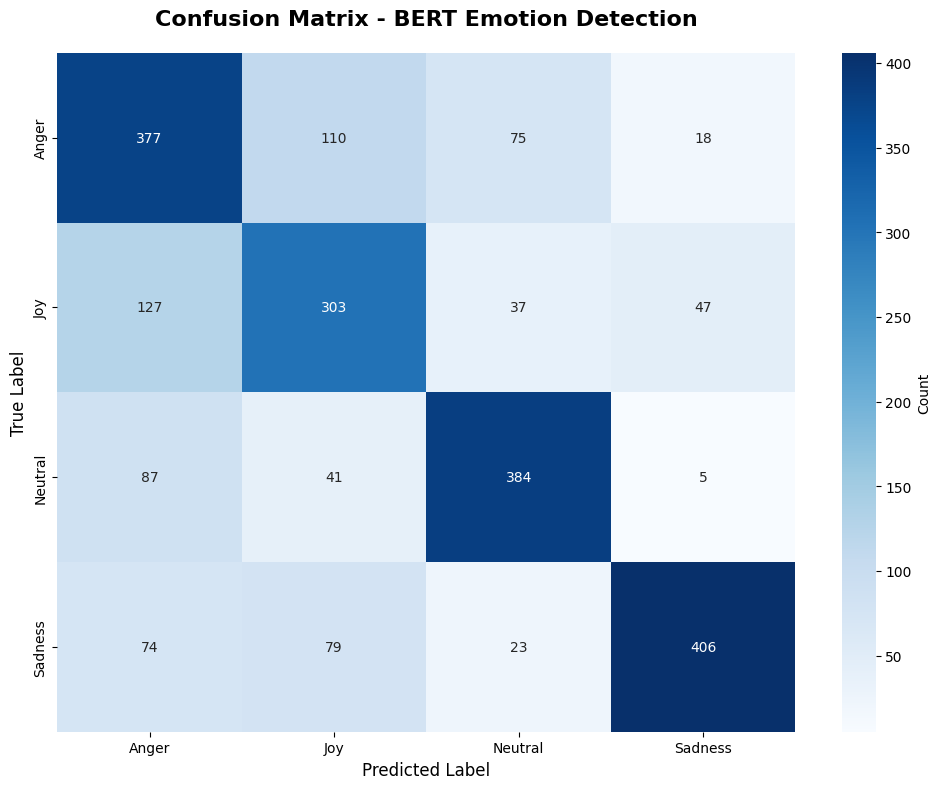


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Anger     0.5669    0.6500    0.6056       580
         Joy     0.5685    0.5895    0.5788       514
     Neutral     0.7399    0.7427    0.7413       517
     Sadness     0.8529    0.6976    0.7675       582

    accuracy                         0.6703      2193
   macro avg     0.6821    0.6700    0.6733      2193
weighted avg     0.6840    0.6703    0.6743      2193



In [32]:
# Cell 18: Generate Predictions and Confusion Matrix
print("GENERATING CONFUSION MATRIX")
# Get predictions on test set
predictions = trainer.predict(tokenized_datasets['test'])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=emotion_labels,
    yticklabels=emotion_labels,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - BERT Emotion Detection', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Print detailed classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(
    true_labels,
    pred_labels,
    target_names=emotion_labels,
    digits=4
))

In [33]:
# Cell 18.5: Enhanced Error Analysis and Model Interpretation
print("ENHANCED ERROR ANALYSIS")
def perform_error_analysis(true_labels, pred_labels, texts, emotion_labels, sample_size=20):
    """
    Comprehensive error analysis function
    - Identifies common confusion patterns
    - Analyzes hard examples
    - Provides insights for model improvement
    """
    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Calculate misclassification rate
    misclassified_mask = true_labels != pred_labels
    misclassification_rate = misclassified_mask.mean()

    print(f"Overall misclassification rate: {misclassification_rate:.2%}")
    print(f"Number of misclassified samples: {misclassified_mask.sum()}")

    # Analyze confusion patterns
    confusion_dict = {}
    for true_idx, pred_idx in zip(true_labels[misclassified_mask], pred_labels[misclassified_mask]):
        key = (emotion_labels[true_idx], emotion_labels[pred_idx])
        confusion_dict[key] = confusion_dict.get(key, 0) + 1

    print("\nMost common confusion patterns:")
    sorted_confusions = sorted(confusion_dict.items(), key=lambda x: x[1], reverse=True)
    for (true_emotion, pred_emotion), count in sorted_confusions[:10]:
        print(f"  {true_emotion} → {pred_emotion}: {count} samples")

    # Collect misclassified examples for detailed analysis
    misclassified_indices = np.where(misclassified_mask)[0]

    print(f"\nDetailed analysis of {min(sample_size, len(misclassified_indices))} misclassified examples:")

    error_samples = []
    for i, idx in enumerate(misclassified_indices[:sample_size]):
        true_emotion = emotion_labels[true_labels[idx]]
        pred_emotion = emotion_labels[pred_labels[idx]]
        text_sample = texts[idx] if isinstance(texts, (list, np.ndarray)) else texts.iloc[idx]

        error_samples.append({
            'text': text_sample,
            'true_emotion': true_emotion,
            'predicted_emotion': pred_emotion
        })

        print(f"\n{i+1}. True: {true_emotion}, Predicted: {pred_emotion}")
        print(f"   Text: {text_sample[:150]}...")

    # Per-class error analysis
    print(f"\n{'='*50}")
    print("PER-CLASS ERROR ANALYSIS")
    print(f"{'='*50}")

    for i, emotion in enumerate(emotion_labels):
        class_mask = true_labels == i
        if class_mask.sum() > 0:
            class_errors = (pred_labels[class_mask] != i).sum()
            class_total = class_mask.sum()
            error_rate = class_errors / class_total

            # Most common incorrect predictions for this class
            incorrect_preds = pred_labels[class_mask & misclassified_mask]
            if len(incorrect_preds) > 0:
                most_common_error = np.bincount(incorrect_preds).argmax()
                most_common_error_name = emotion_labels[most_common_error]
                print(f"\n{emotion.upper()}:")
                print(f"  Error rate: {error_rate:.2%} ({class_errors}/{class_total})")
                print(f"  Most confused with: {most_common_error_name}")

    return error_samples, confusion_dict

# Perform error analysis on test set
print("Performing error analysis on test predictions...")
test_texts = test_df['text'].tolist()
error_samples, confusion_patterns = perform_error_analysis(
    true_labels,
    pred_labels,
    test_texts,
    emotion_labels,
    sample_size=15
)

# Save error analysis results
error_analysis_results = {
    'misclassification_rate': float((true_labels != pred_labels).mean()),
    'confusion_patterns': {f"{true}->{pred}": count for (true, pred), count in confusion_patterns.items()},
    'sample_errors': error_samples[:10]  # Save first 10 for reference
}

with open('error_analysis.json', 'w') as f:
    json.dump(error_analysis_results, f, indent=2)

print("\nError analysis saved to 'error_analysis.json'")

ENHANCED ERROR ANALYSIS
Performing error analysis on test predictions...
Overall misclassification rate: 32.97%
Number of misclassified samples: 723

Most common confusion patterns:
  Joy → Anger: 127 samples
  Anger → Joy: 110 samples
  Neutral → Anger: 87 samples
  Sadness → Joy: 79 samples
  Anger → Neutral: 75 samples
  Sadness → Anger: 74 samples
  Joy → Sadness: 47 samples
  Neutral → Joy: 41 samples
  Joy → Neutral: 37 samples
  Sadness → Neutral: 23 samples

Detailed analysis of 15 misclassified examples:

1. True: Anger, Predicted: Joy
   Text: is awake and does not want to go to work...

2. True: Neutral, Predicted: Anger
   Text: everraven i figured youd be bouncing about it...

3. True: Sadness, Predicted: Anger
   Text: handshake nah ill pass id rather have no finger nails than those yellow horn plates you call nails im out...

4. True: Neutral, Predicted: Anger
   Text: iamkhayyam haha i came home from a long night out and all i saw on tweetie was khayyam wakil i usually 

In [34]:
# Cell 19: Define Prediction Function for Custom Text
def predict_emotion(text, return_all_scores=False):
    """
    Predict emotion for a given text

    Args:
        text (str): Input text to classify
        return_all_scores (bool): If True, return probabilities for all classes

    Returns:
        tuple: (predicted_emotion, confidence) or (predicted_emotion, confidence, all_probabilities)
    """
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()

    predicted_emotion = id2label[predicted_class]

    if return_all_scores:
        all_probs = probabilities[0].cpu().numpy()
        return predicted_emotion, confidence, all_probs
    else:
        return predicted_emotion, confidence

print("Prediction function defined!")
print("Usage: predict_emotion('Your text here')")


Prediction function defined!
Usage: predict_emotion('Your text here')


In [35]:
# Cell 20: Test with Custom Examples
print("TESTING WITH CUSTOM EXAMPLES")
# Define test examples
test_examples = [
    "I am so happy and excited about this wonderful news!",
    "This makes me really angry and frustrated with everything.",
    "I feel so sad and depressed about the situation.",
    "The weather is quite normal today, nothing special.",
    "I love spending time with my family on weekends!",
    "Why does everything always go wrong for me?",
    "That movie was absolutely terrible and disappointing.",
    "I'm feeling great today, full of energy!",
]
# Predict emotions for all examples
print("\nPredictions:")
for i, text in enumerate(test_examples, 1):
    emotion, confidence = predict_emotion(text)
    print(f"\n{i}. Text: {text}")
    print(f"   Predicted Emotion: {emotion.upper()}")
    print(f"   Confidence: {confidence:.2%}")


TESTING WITH CUSTOM EXAMPLES

Predictions:

1. Text: I am so happy and excited about this wonderful news!
   Predicted Emotion: NEUTRAL
   Confidence: 97.81%

2. Text: This makes me really angry and frustrated with everything.
   Predicted Emotion: ANGER
   Confidence: 98.31%

3. Text: I feel so sad and depressed about the situation.
   Predicted Emotion: SADNESS
   Confidence: 90.89%

4. Text: The weather is quite normal today, nothing special.
   Predicted Emotion: JOY
   Confidence: 57.40%

5. Text: I love spending time with my family on weekends!
   Predicted Emotion: NEUTRAL
   Confidence: 94.03%

6. Text: Why does everything always go wrong for me?
   Predicted Emotion: SADNESS
   Confidence: 78.08%

7. Text: That movie was absolutely terrible and disappointing.
   Predicted Emotion: SADNESS
   Confidence: 66.52%

8. Text: I'm feeling great today, full of energy!
   Predicted Emotion: NEUTRAL
   Confidence: 96.92%


In [36]:
# Cell 21: Save Sample Predictions to CSV
print("\n" + "="*70)
print("GENERATING SAMPLE PREDICTIONS")
print("="*70)
# Randomly sample from test set
sample_size = min(20, len(test_df))
sample_indices = np.random.choice(len(test_df), size=sample_size, replace=False)
# Collect predictions
sample_results = []
for idx in sample_indices:
    text = test_df.iloc[idx]['text']
    true_emotion = test_df.iloc[idx]['emotion']

    pred_emotion, confidence = predict_emotion(text)

    sample_results.append({
        'text': text[:100] + ('...' if len(text) > 100 else ''),
        'true_emotion': true_emotion,
        'predicted_emotion': pred_emotion,
        'confidence': confidence,
        'correct': true_emotion == pred_emotion
    })
# Create dataframe
results_df = pd.DataFrame(sample_results)

# Display results
print(f"\nSample Predictions (n={sample_size}):")
print(results_df.to_string(index=False))
# Calculate accuracy on sample
sample_accuracy = results_df['correct'].mean()
print(f"\nSample Accuracy: {sample_accuracy:.2%}")
# Save to CSV
results_df.to_csv('sample_predictions.csv', index=False)
print("\nSample predictions saved to 'sample_predictions.csv'")



GENERATING SAMPLE PREDICTIONS

Sample Predictions (n=20):
                                                                                                   text true_emotion predicted_emotion  confidence  correct
                 anyone know a good png compression tool for os x tried pngcrush but it just doesnt run          Joy           Sadness    0.443936    False
                                heeders again and on monday as well absolutely no plans for the weekend      Sadness               Joy    0.618169    False
alyssamilano we had a local pet store get shut down last for something like thatits horrible what so...      Sadness           Sadness    0.439914     True
i really despair over the whole copyright situation being visually impaired means you dont deserve t...      Sadness             Anger    0.567249    False
                                                                     field day is sad no ribbons for me      Sadness           Sadness    0.929269     True
     

In [37]:
# Cell 22: Save the Fine-tuned Model
print("Saving Fine Tuned Model")
output_dir = './bert_emotion_model'
os.makedirs(output_dir, exist_ok=True)
# Save model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to: {output_dir}")
print("\nSaved files:")
for file in os.listdir(output_dir):
    print(f"  - {file}")
print("\nTo load this model later:")
print(f"  tokenizer = BertTokenizer.from_pretrained('{output_dir}')")
print(f"  model = BertForSequenceClassification.from_pretrained('{output_dir}')")


Saving Fine Tuned Model
Model saved to: ./bert_emotion_model

Saved files:
  - vocab.txt
  - config.json
  - special_tokens_map.json
  - model.safetensors
  - tokenizer_config.json

To load this model later:
  tokenizer = BertTokenizer.from_pretrained('./bert_emotion_model')
  model = BertForSequenceClassification.from_pretrained('./bert_emotion_model')


In [38]:
# Cell 23: Create and Save Training Summary
print("CREATING TRAINING SUMMARY")
# Compile all metrics
summary = {
    'task': 'Emotion Detection',
    'model_architecture': 'BERT (Encoder-only)',
    'model_name': model_name,
    'dataset_size': len(df),
    'train_size': len(train_df),
    'validation_size': len(val_df),
    'test_size': len(test_df),
    'num_classes': num_labels,
    'class_names': emotion_labels,
    'training_config': {
        'learning_rate': training_args.learning_rate,
        'batch_size': training_args.per_device_train_batch_size,
        'num_epochs': training_args.num_train_epochs,
        'weight_decay': training_args.weight_decay,
        'warmup_steps': training_args.warmup_steps,
    },
    'training_results': {
        'final_training_loss': float(train_result.training_loss),
        'training_time_seconds': float(train_result.metrics['train_runtime']),
    },
    'validation_results': {
        'accuracy': float(val_results['eval_accuracy']),
        'f1_macro': float(val_results['eval_f1_macro']),
        'f1_weighted': float(val_results['eval_f1_weighted']),
    },
    'test_results': {
        'accuracy': float(test_results['eval_accuracy']),
        'f1_macro': float(test_results['eval_f1_macro']),
        'f1_weighted': float(test_results['eval_f1_weighted']),
    }
}

# Save summary as JSON
import json
with open('training_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

print("Training Summary:")
print(json.dumps(summary, indent=2))

print("\nSummary saved to 'training_summary.json'")




CREATING TRAINING SUMMARY
Training Summary:
{
  "task": "Emotion Detection",
  "model_architecture": "BERT (Encoder-only)",
  "model_name": "bert-base-uncased",
  "dataset_size": 21922,
  "train_size": 17537,
  "validation_size": 2192,
  "test_size": 2193,
  "num_classes": 4,
  "class_names": [
    "Anger",
    "Joy",
    "Neutral",
    "Sadness"
  ],
  "training_config": {
    "learning_rate": 2e-05,
    "batch_size": 16,
    "num_epochs": 4,
    "weight_decay": 0.01,
    "warmup_steps": 500
  },
  "training_results": {
    "final_training_loss": 0.6655119641216212,
    "training_time_seconds": 376.6558
  },
  "validation_results": {
    "accuracy": 0.6541970802919708,
    "f1_macro": 0.6584827176958766,
    "f1_weighted": 0.6596861598123329
  },
  "test_results": {
    "accuracy": 0.6703146374829001,
    "f1_macro": 0.6733044037958509,
    "f1_weighted": 0.6742808539363343
  }
}

Summary saved to 'training_summary.json'
